In [29]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
# understanding derivatives
def f(x):
    return 3*x**2 - 4*x + 5

In [31]:
f(3.0)

20.0

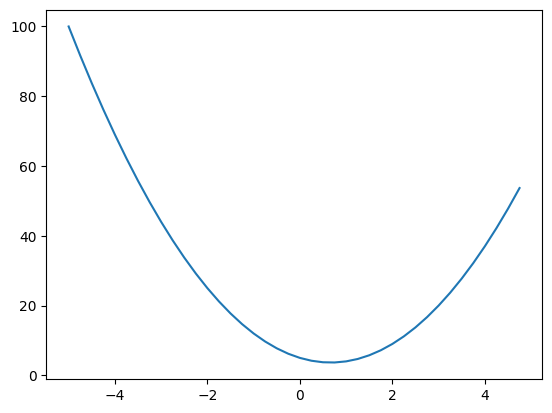

In [32]:
# let's plot the function to determine shape (parabola)
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [33]:
# now calculate derivatives (3*2*x - 4)
h = 0.001
x = 3.0
(f(x + h) - f(x))/h

14.00300000000243

In [34]:
# bit more complex:
def f(a, b, c):
    return a * b + c

a = 2.0
b = -3.0
c = 10.0
print(f(a, b, c))

4.0


In [35]:
h = 0.001
d1 = f(a, b, c)
c += h
d2 = f(a, b, c)
print('d1', d1)
print('d2', d2)

d1 4.0
d2 4.0009999999999994


In [36]:
print('slope', (d2 - d1)/h)

slope 0.9999999999994458


In [37]:
math.exp(1)

2.718281828459045

In [38]:
# building out neural network basics
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0 # changing the variable does not change the loss function
        self._backward = lambda: None
        self._prev = set(_children) # previous nodes
        self._op = _op # what operation created result
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        # now we want to propagate the gradient:
        def _backward():
            self.grad = 1.0 * out.grad # local derivative of self in addition is 1.0
            other.grad = 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)

        out = Value(t, (self, ) ,'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward

        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label='e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d*f
L.label='L'
L

Value(data=-8.0)

In [39]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [40]:
d._op

'+'

In [41]:
from graphviz import Digraph

def trace(root):
    # build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})

    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of operation create op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 node to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

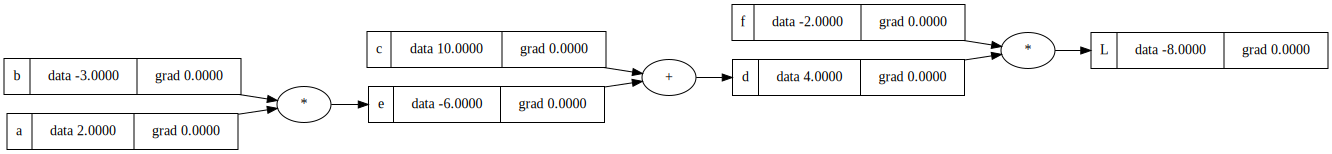

In [42]:
draw_dot(L)

### Manual backpropagation

-2.000000000000668


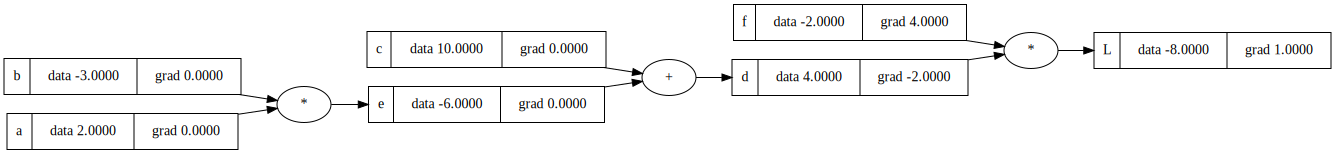

In [43]:
# https://www.youtube.com/watch?v=VMj-3S1tku0&ab_channel=AndrejKarpathy

# if we change L by h we expect the entire function to change by h so the derivative should be 1
# proof:
# dL/dL = 1
# function changes linearly

# for * node we can determine gradients this way:
# L = d * f
# dL/dd =? f
# change d (x) by tiny amount h:
# (f(x+h)-f(x))/h = (fx + fh - fx)/h = fh/h = f

# this will mean:
# f.grad = d
# d.grad = f


L.grad = 1
d.grad = -2.0
f.grad = 4.0

def lol():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label='e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f
    L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label='e'
    d = e + c
    d.label = 'd'
    d.data += h # for gardient check... numerical verification that we calculated f.grade correctly
    f = Value(-2.0, label='f')
    L = d*f
    L.label='L'
    L2 = L.data

    print((L2-L1) / h)

lol()

draw_dot(L)


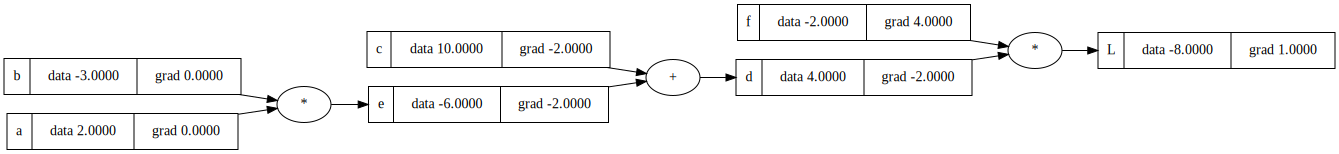

In [44]:
'''
next we need to understand dL by dc, i.e. dL/dc
focusing on d only we know that L get impacted by c through d so what is the impact of c on d?
dd / dc = ?
we know that d = c + e so dd/dc = 1.0
proof (input c+e for x):
(f(x+h) - f(x))/h = (c + h + e) - (c + e) / h = h/h = 1

dd / de = 1.0 - this is just local node derivative and we need to continue

WANT:
dL by dc i.e. dL / dc

KNOW:
dL / dd

applying chain rule:
dL/de = dL/dd * dd/de = -2.0 * 1.0 = -2.0
'''
c.grad = -2.0
e.grad = -2.0 # explain why :-)

draw_dot(L)

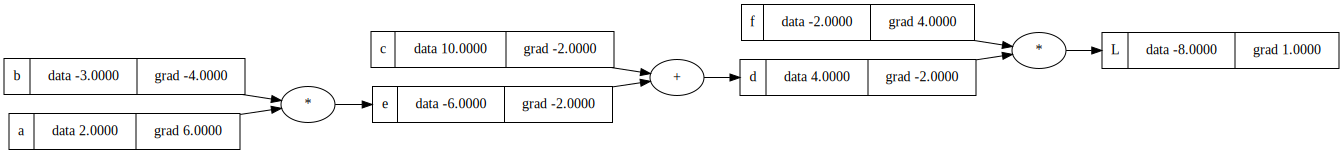

In [45]:
'''
let's do the final part here finding dL / db and dL / da
we know that e = a * b
first we will do de / da which we expect to be b
and symetrically de / db = a

these are just local so we need to continue applying chain rule knowing that e = a * b

WANT:
dL / da

KNOW:
dL / dd; dL / de; dd/de but we just need the node we are backpropagating from i.e. dL/de and 
we are not traversing across entire chain

WRONG: dL/dd * dd/de * de/da
RIGHT: dL/de * de/da

applying chain rule:
dL / da = dL/de * de/da = -2.0 * b = -3.0 == 6.0
dl / db = dL/de * de/db = -2.0 * a = 2.0 == -4
'''
a.grad = 6.0
b.grad = -4.0
draw_dot(L)

In [46]:
'''
Let's increase the value of some leaf nodes by 0.01 to see impact on L
'''
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L)

Value(data=-7.286496)


### Manual backpropagation example with neuron

In [47]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')
# according to neuron model (wikipedia)
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

In [48]:
# take this through the activation function tanh
# tanh we need to implement in Value class (check code above)
o = n.tanh(); o.label = 'o'

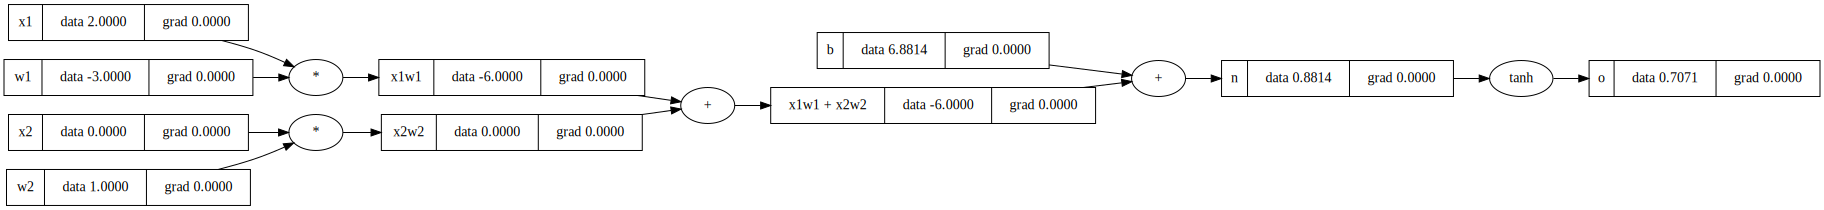

In [49]:
draw_dot(o)

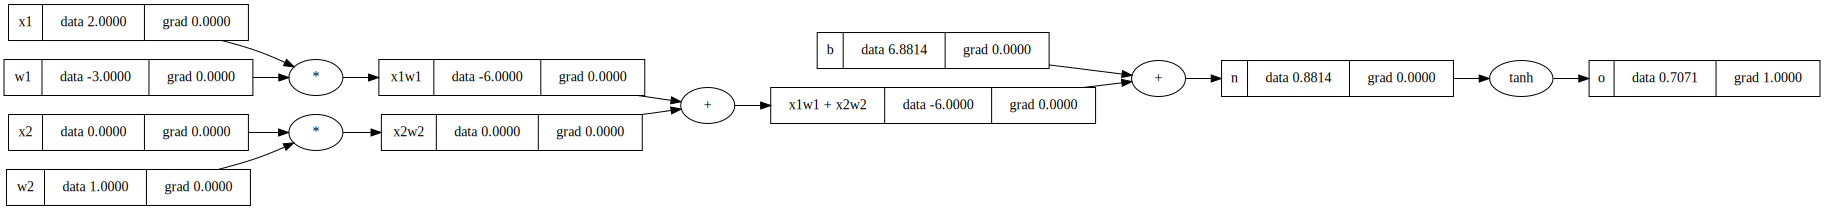

In [50]:
# starting the backpropagation
# STEP 1: what is the derivative of o with respect to o? it's 1
o.grad = 1
draw_dot(o)

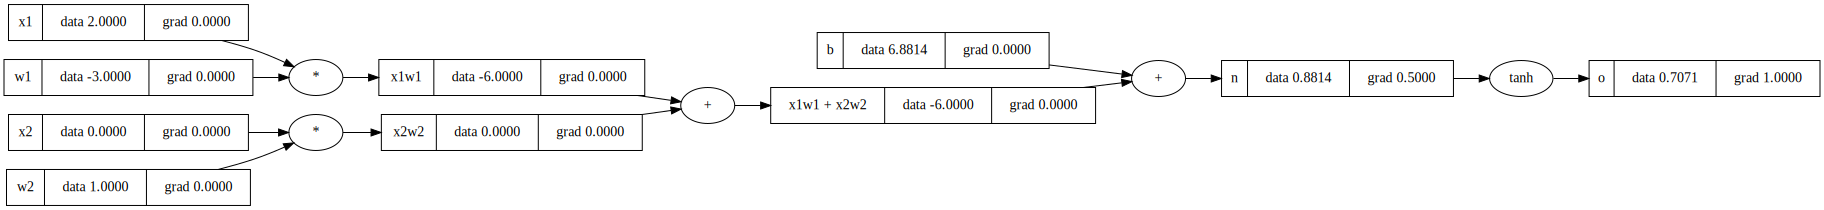

In [51]:
# STEP 2: if o = tanh(n) what is do/dn?
# do/dn = 1 - (tanh(n**2)) = 1 - o**2
n.grad = 1 - o.data**2
draw_dot(o)

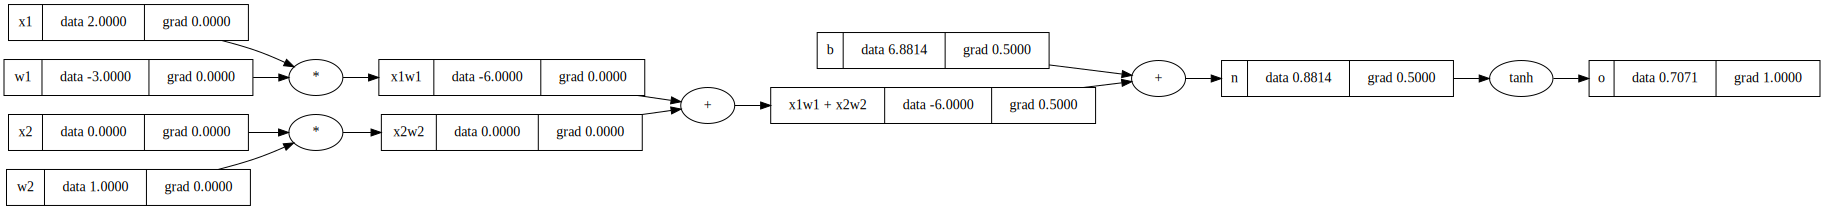

In [52]:
# STEP 3: What is do / db
# WE KNOW that + operation just routes next gradient so 0.5 will go both into b and x1w1+x2w2
b.grad = 0.5
x1w1x2w2.grad = 0.5
draw_dot(o)

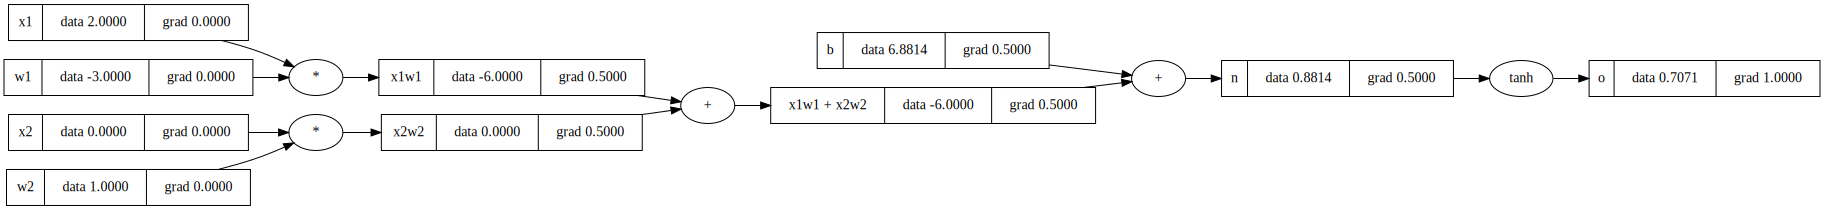

In [53]:
# STEP 4 - same as STEP3
x1w1.grad = 0.5
x2w2.grad = 0.5
draw_dot(o)

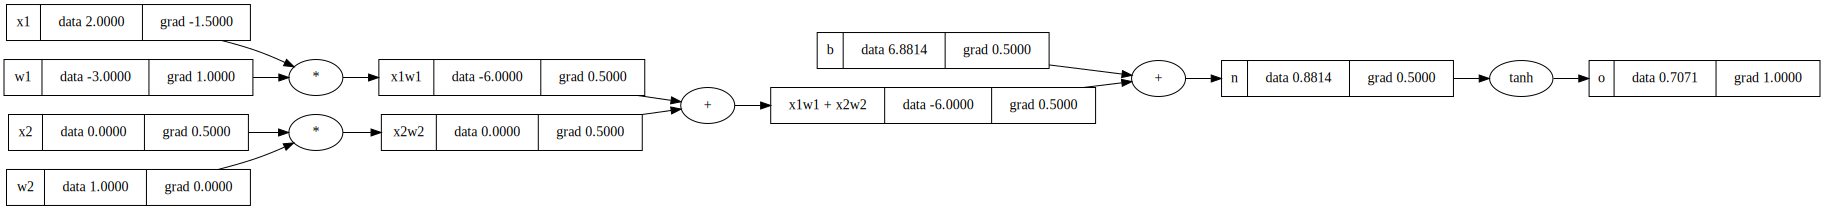

In [54]:
# STEP 5
# what id do/dx1 ? 
# we know that x1w1 = x1 * w1 so dx1w1/dx1 = w1 and dx1w1/w1 = x1

# apply chain rule : do/dx1 = do/dx1w1 * dx1w1/dx1 (which is w1) = 0.5 * -3.0
# and also : do/dw1 = do/dx1w1 * dx1w1/dw1 (which is x1) = 0.5 * 2
x1.grad = 0.5 * -3.0
w1.grad = 1.0


# similarly x2.grad = do/dx2?
# do/dx2 = do/dw2x2 * dw2x2/dx2 (which is w2) so it means that x2.grad = x2w2.grad * w2.data
x2.grad = 0.5 * 1.0
w2.grad = 0.5 * 0
draw_dot(o)

To implement backpropagation now we go back to Value object and create self._backward = lambda: None
After implementation of _backward functions we can re-run the backpropagation to check if it works

In [55]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')
# according to neuron model (wikipedia)
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

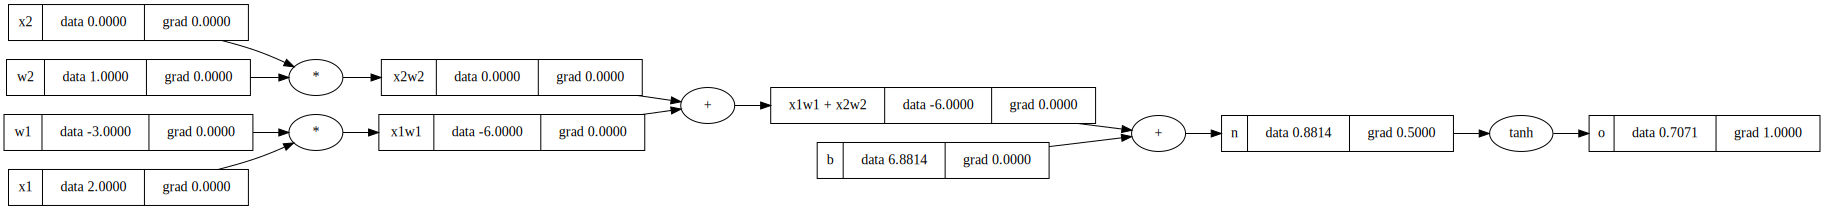

In [56]:
# initialize o.grad
o.grad = 1.0
o._backward()
draw_dot(o)

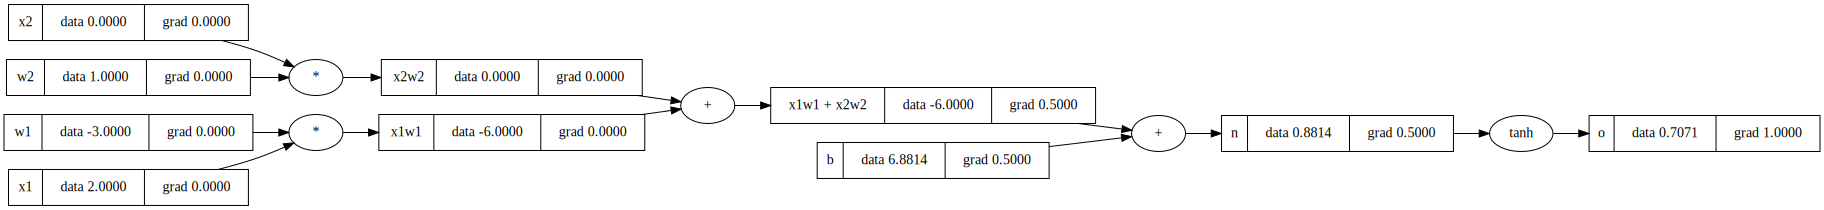

In [58]:
n._backward()
draw_dot(o)

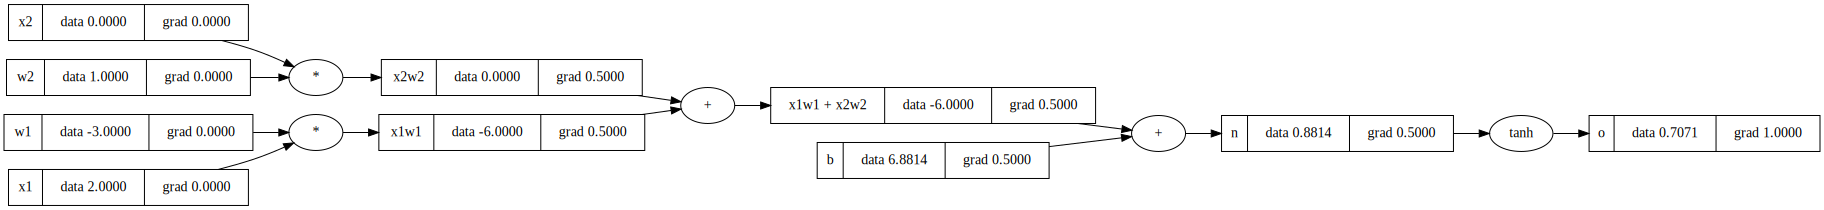

In [59]:
x1w1x2w2._backward()
draw_dot(o)

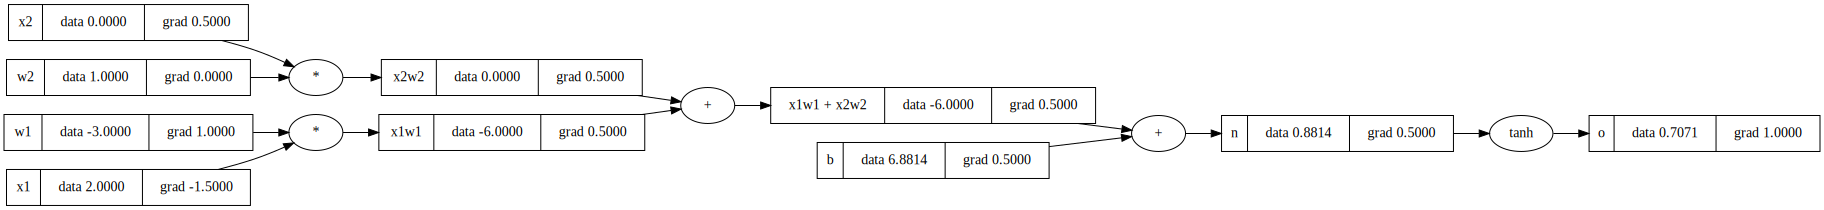

In [60]:
x1w1._backward()
x2w2._backward()
draw_dot(o)